In [1]:
import pandas as pd
import io
import os
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from random import randint
from itertools import chain

---
Вынесенные функции загрузки данных

In [2]:
# скрипт загрузки всех данных по образцам bedcov
def load_bedcov_all_genes_from_panel(panel_folder = "bedcoverage"):
    # Подгрузим образцы
    file_path = "./Data/" + panel_folder + "/"
    files = os.listdir(file_path)

    # Датасет куда загружены все образцы, монстр
    df = []
    for i in files:
        df_i = pd.read_table(file_path + i, delimiter="\t", header = None)
        df_i.columns = ["chr", "start_gene", "end_gene", "gene_name", "nucleotide_in_exon", str(i)]
        df.append(df_i)

    # Проверка совместимости датасетов
    for i in range(0,len(df)):
        if (df[i].loc[:, ["chr", "start_gene", "end_gene", "nucleotide_in_exon"]].equals(df[0].loc[:, ["chr", "start_gene", "end_gene", "nucleotide_in_exon"]])) == False:
            print("Загруженные регионы bedcoverage не совпадают между образцов")

    # Совместим и перепишем в df
    for i in range(0,len(df)):
        df[0] = pd.merge(df[0], df[i], how = 'left')
    df = df[0]

    print("panel:", panel_folder, "coverage data loaded")
    return df

In [3]:
# скрипт загрузки данных samtools
def load_samtools_data(panel_folder = "samtools"):
    file_path = "./Data/" + panel_folder + "/"
    files = os.listdir(file_path)
    name_of_samples = []
    for i in files:
        name_of_samples.append(i.split(".")[0])

    df_total_reads = pd.DataFrame(columns = ["sample", "number of mapped reads"])
    df_total_reads["sample"] = name_of_samples
    df_total_reads = df_total_reads.set_index('sample')
    number_of_mapped_reads = []
    
    for i in files:
        with open(file_path + i) as f:
            j = f.read()[:-2]   # убираем перенос строки
        number_of_mapped_reads.append(j)
    df_total_reads["number of mapped reads"] = number_of_mapped_reads

    print("samtools data from folder ", panel_folder, " loaded")
    print("names of samples ", name_of_samples)
    return df_total_reads

In [29]:
# функция, в которой от датафрейма убирается все куски вне экзонов и каждой строчке приписывается номер экзона
def df_exon_filter(df, df_exons):
    df_for_return = df.copy()

    # Добавим колонку с номером экзона для удобства
    exon_data = pd.Series(data=[]*df_for_return.shape[0], dtype=int)
    df_for_return['exon_data'] = exon_data

    # кусок кода, который оставляет от таблицы только экзоны из панели (и для образцов и для контролей)
    df_new = pd.DataFrame()
    for index, row in df_exons.iterrows():
        # для каждого экзона найдём его строки, в образцах и контроле
        df_this_exon = df_for_return[df_for_return[["start_gene", "nucleotide_in_exon"]].sum(axis=1) >= row["start"]]
        df_this_exon = df_this_exon[df_this_exon[["start_gene", "nucleotide_in_exon"]].sum(axis=1) <= row["end"]]
        df_this_exon['exon_data'] = index + 1

        # и склеим их в один датасет
        df_new = pd.concat([df_new, df_this_exon], sort=False)
    # и делает сквозную нумерацию по экзонам
    df_for_return = df_new.reset_index(drop=True)

    # удалим нафиг колонки с началом и концом гена
    df_for_return = df_for_return.drop("start_gene", 1)
    df_for_return = df_for_return.drop("end_gene", 1)
        
    return df_for_return

Продолжение загрузки данных

In [4]:
table_of_panels = pd.DataFrame(columns = ["panel", "sample"])

with open("names_of_samples_dislipid_third", "r+") as file:
    for line in file:
        table_of_panels.loc[len(table_of_panels)] = [line.split(".")[0].split("/")[-2], line.split(".")[0].split("/")[-1]]  # колдунство где мы из полного пути файла вырезаем название панели и номер образца

table_of_panels

,panel,sample
0,allPanels_hg38,IPPM0749_1
1,allPanels_hg38,IPPM1070
2,allPanels_hg38,IPPM1352
3,allPanels_hg38,IPPM1386
4,allPanels_hg38,IPPM1403
...,...,...
83,DOOM_hg38,IPPM2375
84,DOOM_hg38,IPPM2387
85,DOOM_hg38,IPPM2389
86,DOOM_hg38,IPPM2445


In [41]:
df  = load_bedcov_all_genes_from_panel()

df

panel: bedcoverage coverage data loaded


,chr,start_gene,end_gene,gene_name,nucleotide_in_exon,IPPM1830.realigned.bam.bedcoverage,IPPM1994_2.realigned.bam.bedcoverage,IPPM1986.realigned.bam.bedcoverage,IPPM2002.realigned.bam.bedcoverage,IPPM1427.realigned.bam.bedcoverage,...,IPPM2237.realigned.bam.bedcoverage,IPPM2287.realigned.bam.bedcoverage,HTG004.realigned.bam.bedcoverage,IPPM1731.realigned.bam.bedcoverage,IPPM2007.realigned.bam.bedcoverage,IPPM1733.realigned.bam.bedcoverage,IPPM1500.realigned.bam.bedcoverage,IPPM2286.realigned.bam.bedcoverage,IPPM2095.realigned.bam.bedcoverage,IPPM1927_2.realigned.bam.bedcoverage
0,chr1,21509361,21509552,ALPL,1,22,2,0,23,1,...,23,15,0,0,0,0,0,18,0,0
1,chr1,21509361,21509552,ALPL,2,24,2,0,25,1,...,23,16,0,0,0,0,0,18,0,0
2,chr1,21509361,21509552,ALPL,3,30,2,0,28,1,...,23,16,0,0,0,0,0,18,0,0
3,chr1,21509361,21509552,ALPL,4,31,2,0,30,1,...,23,16,0,0,0,0,0,22,0,0
4,chr1,21509361,21509552,ALPL,5,30,2,0,29,1,...,24,17,0,0,0,0,0,23,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169159,chr9,104927899,104928190,ABCA1,287,69,0,0,79,2,...,76,91,0,0,0,0,0,82,0,0
169160,chr9,104927899,104928190,ABCA1,288,68,0,0,77,2,...,75,89,0,0,0,0,0,81,0,0
169161,chr9,104927899,104928190,ABCA1,289,67,0,0,76,2,...,73,87,0,0,0,0,0,78,0,0
169162,chr9,104927899,104928190,ABCA1,290,68,0,0,74,2,...,71,89,0,0,0,0,0,76,0,0


In [42]:
# Сделаем список полных названий ключевых файлов, для сбора данных, не забудем удалить все добавленные колонки
samples = df.columns.values.tolist()
samples.remove("chr")
samples.remove("start_gene")
samples.remove("end_gene")
samples.remove("gene_name")
samples.remove("nucleotide_in_exon")
print("list of samples", samples)  

list of samples ['IPPM1830.realigned.bam.bedcoverage', 'IPPM1994_2.realigned.bam.bedcoverage', 'IPPM1986.realigned.bam.bedcoverage', 'IPPM2002.realigned.bam.bedcoverage', 'IPPM1427.realigned.bam.bedcoverage', 'IPPM0558.realigned.bam.bedcoverage', 'IPPM0425.realigned.bam.bedcoverage', 'IPPM1729_2.realigned.bam.bedcoverage', 'IPPM2007_2.realigned.bam.bedcoverage', 'IPPM0729.realigned.bam.bedcoverage', 'IPPM1731_2.realigned.bam.bedcoverage', 'IPPM1431.realigned.bam.bedcoverage', 'IPPM2145.realigned.bam.bedcoverage', 'IPPM1415.realigned.bam.bedcoverage', 'IPPM2006.realigned.bam.bedcoverage', 'IPPM1831_2.realigned.bam.bedcoverage', 'IPPM1386.realigned.bam.bedcoverage', 'IPPM1521.realigned.bam.bedcoverage', 'IPPM1352.realigned.bam.bedcoverage', 'IPPM1729.realigned.bam.bedcoverage', 'IPPM1428.realigned.bam.bedcoverage', 'IPPM1615.realigned.bam.bedcoverage', 'IPPM1093.realigned.bam.bedcoverage', 'IPPM1825.realigned.bam.bedcoverage', 'IPPM1378.realigned.bam.bedcoverage', 'IPPM2387.realigned.bam

In [34]:
df_total_reads = load_samtools_data()
df_total_reads

samtools data from folder  samtools  loaded
names of samples  ['HTG002', 'IPPM0796', 'IPPM2285', 'IPPM1584', 'IPPM2237', 'IPPM1427', 'IPPM1825', 'IPPM1830', 'IPPM2002', 'IPPM1070', 'IPPM1516', 'IPPM2145', 'IPPM1986', 'IPPM2118', 'IPPM1729', 'IPPM1363', 'IPPM1615', 'IPPM1146', 'IPPM1994_2', 'IPPM2038', 'IPPM1606', 'IPPM1994', 'IPPM1676_2', 'IPPM1986_2', 'IPPM2286', 'IPPM2389', 'IPPM2007_2', 'IPPM1733', 'IPPM2044', 'IPPM1455_1', 'IPPM1378', 'IPPM1415', 'IPPM2125', 'IPPM2026', 'IPPM1433_1', 'IPPM1500', 'IPPM1186_1', 'IPPM1521', 'IPPM1173', 'IPPM1431', 'IPPM1733_2', 'HTG004', 'IPPM1005', 'IPPM1386', 'IPPM1426', 'IPPM1454_1', 'IPPM0425', 'IPPM1319', 'IPPM1428', 'IPPM2006_2', 'IPPM0415', 'IPPM1676', 'IPPM1729_2', 'IPPM1337', 'IPPM2007', 'IPPM1379', 'IPPM1093', 'IPPM1352', 'IPPM0558', 'IPPM1927_2', 'IPPM1028', 'IPPM1831', 'IPPM1382', 'HTG003', 'IPPM1615_2', 'IPPM1731_2', 'IPPM2387', 'IPPM2006', 'IPPM1599', 'IPPM1170', 'IPPM1924', 'IPPM1731', 'IPPM1927', 'IPPM0749_1', 'IPPM2011', 'IPPM2287', '

,number of mapped reads
sample,
HTG002,358602
IPPM0796,335253
IPPM2285,1056587
IPPM1584,356006
IPPM2237,1013347
...,...
IPPM1808,1044665
IPPM2375,861987
IPPM1831_2,381368


---
PCA анализ

In [8]:
df_for_PCA = df[samples].T # каждой строке - образцу - в соответствии его покрытия везде

df_for_PCA

,0,1,2,3,4,5,6,7,8,9,...,169154,169155,169156,169157,169158,169159,169160,169161,169162,169163
IPPM1830.realigned.bam.bedcoverage,22,24,30,31,30,29,29,29,29,30,...,75,73,72,72,70,69,68,67,68,66
IPPM1994_2.realigned.bam.bedcoverage,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
IPPM1986.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM2002.realigned.bam.bedcoverage,23,25,28,30,29,30,30,30,31,29,...,83,83,81,81,81,79,77,76,74,72
IPPM1427.realigned.bam.bedcoverage,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IPPM1733.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM1500.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM2286.realigned.bam.bedcoverage,18,18,18,22,23,23,23,23,24,27,...,84,84,84,83,83,82,81,78,76,73
IPPM2095.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Для pca анализа отдельной панели
panel_samples = table_of_panels.loc[table_of_panels["panel"] == "allPanels_hg38"]["sample"].to_list()
panel_samples_full_names = []
for i in panel_samples:
    panel_samples_full_names.append(i + ".realigned.bam.bedcoverage")

df_for_PCA = df.loc[:, panel_samples_full_names].T 
df_for_PCA

,0,1,2,3,4,5,6,7,8,9,...,169154,169155,169156,169157,169158,169159,169160,169161,169162,169163
IPPM0749_1.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM1070.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM1352.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM1386.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM1403.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM1415.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM1426.realigned.bam.bedcoverage,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
IPPM1427.realigned.bam.bedcoverage,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
IPPM1428.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IPPM1431.realigned.bam.bedcoverage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
scaler = StandardScaler()
df_for_PCA_2 = scaler.fit_transform(df_for_PCA) # стандартизация scaler

n_components = 20
pca = PCA(n_components = n_components)
pca.fit(df_for_PCA_2)
X_pca = pca.transform(df_for_PCA_2)

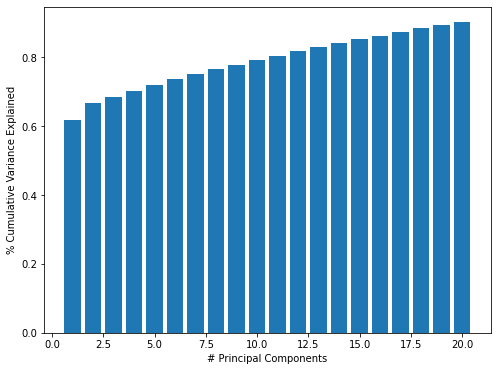

In [66]:
# Calculate cumulative explained variance across all PCs
cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# Plot cumulative explained variance for all PCs
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1, n_components + 1), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

In [70]:
# initializing the PCA
pca = PCA(n_components=3)

# training the model on the dataset
principal_components = pca.fit_transform(df_for_PCA)  # df_for_PCA -- первый вариант нормализации. Индексы у них одинаковые.
principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

final_df = principal_df.copy()
final_df["target"] = df_for_PCA.index

final_df

,principal component 1,principal component 2,principal component 3,target
0,7879.234169,-2586.453209,661.674548,IPPM0749_1.realigned.bam.bedcoverage
1,8349.536591,-2803.238087,991.196728,IPPM1070.realigned.bam.bedcoverage
2,15336.649017,6895.310482,-686.592668,IPPM1352.realigned.bam.bedcoverage
3,21517.495653,6967.896794,5271.263961,IPPM1386.realigned.bam.bedcoverage
4,26508.699052,6255.434858,-2756.029251,IPPM1403.realigned.bam.bedcoverage
5,11094.467937,-3105.147090,-753.038142,IPPM1415.realigned.bam.bedcoverage
6,5771.434135,-3590.784993,-474.090540,IPPM1426.realigned.bam.bedcoverage
7,11074.974081,-3072.058100,-908.759566,IPPM1427.realigned.bam.bedcoverage
8,23826.982982,5386.327492,-2651.736930,IPPM1428.realigned.bam.bedcoverage
9,9274.096430,-3312.504118,-20.585731,IPPM1431.realigned.bam.bedcoverage


In [15]:
# initializing the PCA
pca = PCA(n_components=2)

# training the model on the dataset
principal_components = pca.fit_transform(df_for_PCA)
principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])

final_df = principal_df.copy()
final_df["target"] = df_for_PCA.index

final_df

,principal component 1,principal component 2,target
0,-17780.883016,-14439.449980,IPPM1830.realigned.bam.bedcoverage
1,-16335.817195,-2531.042455,IPPM1994_2.realigned.bam.bedcoverage
2,6726.039504,-25616.259062,IPPM1986.realigned.bam.bedcoverage
3,-18553.906424,-15871.099205,IPPM2002.realigned.bam.bedcoverage
4,-4473.747565,15005.989642,IPPM1427.realigned.bam.bedcoverage
...,...,...,...
83,9960.929059,-25839.238379,IPPM1733.realigned.bam.bedcoverage
84,-5977.624479,14471.759431,IPPM1500.realigned.bam.bedcoverage
85,-17472.813150,-14766.924561,IPPM2286.realigned.bam.bedcoverage
86,-18035.811988,-4504.545320,IPPM2095.realigned.bam.bedcoverage


In [71]:
# Определим панели и покраску цветов:
c = []
for i in final_df["target"]:
    for j in range(len(table_of_panels["sample"])):
        if i.split(".")[0] == table_of_panels["sample"][j]:
            panel_of_this_sample =  table_of_panels["panel"][j]

            if (panel_of_this_sample == "allPanels_hg38"):
                c.append("r")
            elif (panel_of_this_sample == "CAD_hg38"):
                c.append("g")
            elif (panel_of_this_sample == "dislipid_second_hg38"):
                c.append("r")
            elif (panel_of_this_sample == "DOOM_hg38"):
                c.append("y")
            elif (panel_of_this_sample == "truseq_hg38"):
                c.append("b")
            else:
                print("Mistake with sample", i.split(".")[0], ", supposed panel", panel_of_this_sample)

#c

In [60]:
# Разноцветный покрас для определения аутсайдеров
random_c = []
n = len(table_of_panels["sample"])
for i in range(n):
    random_c.append('#%06X' % randint(0, 0xFFFFFF))

#random_c

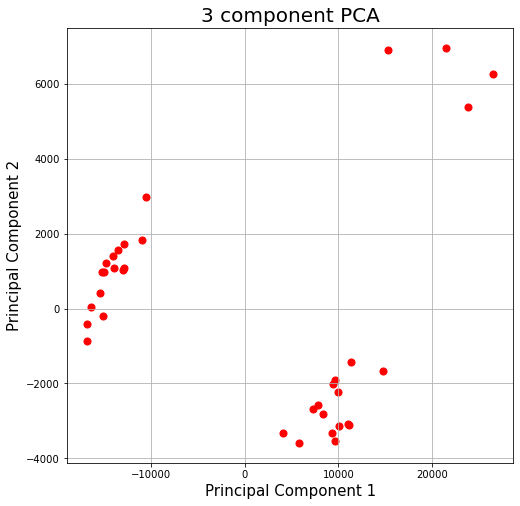

In [72]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

targets = final_df["target"]

colors = c
for target, color in zip(targets,colors):
    #if target == "IPPM0749_1.realigned.bam.bedcoverage": # модуль для проверки правильности определения аутлайров
    #    continue

    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
#ax.legend(targets)
ax.grid()


In [77]:
# Выделим группы
the_1d_group = final_df.loc[final_df["principal component 1"] < 0]["target"].to_list()
the_2d_group = final_df.loc[final_df["principal component 2"] < -1600]["target"].to_list()
the_3d_group = final_df.loc[final_df["principal component 2"] > 4000]["target"].to_list()

In [141]:
# функция, котороя вернёт цвет в завимости от того в какую группу попал образец на pca
def color_of_sample_based_on_pca(sample):
    if sample in the_1d_group:
        return "r"
    if sample in the_2d_group:
        return "g"
    if sample in the_3d_group:
        return "b"


In [63]:
table_of_panels.loc[table_of_panels['sample'] == "IPPM1831"]  #IPPM1173, IPPM0796

,panel,sample
42,CAD_hg38,IPPM1831


In [14]:
table_of_panels.loc[table_of_panels['panel'] == "allPanels_hg38"] 

,panel,sample
0,allPanels_hg38,IPPM0749_1
1,allPanels_hg38,IPPM1070
2,allPanels_hg38,IPPM1352
3,allPanels_hg38,IPPM1386
4,allPanels_hg38,IPPM1403
5,allPanels_hg38,IPPM1415
6,allPanels_hg38,IPPM1426
7,allPanels_hg38,IPPM1427
8,allPanels_hg38,IPPM1428
9,allPanels_hg38,IPPM1431


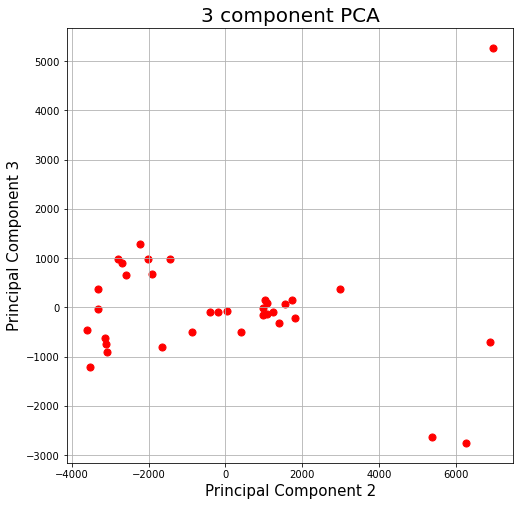

In [72]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

targets = final_df["target"]

colors = c
for target, color in zip(targets,colors):
    if target == "IPPM.realigned.bam.bedcoverage": # модуль для проверки правильности определения аутлайров
        continue

    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 2']
               , final_df.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
#ax.legend(targets)
ax.grid()

---

Часть которая относится к построению графика покрытия по выбранному гену и панели.

In [14]:
gene_title = "LPL"
panel_title = "allPanels_hg38"

In [63]:
# Загрузка данных по всем генам панели и выделение из них данных только по интересующему нас гену
genes_regions_panel_data = pd.read_table("./Data/panels_merge_genes_annotated_lipids_panel_sorted.uniq.bed", 
                                            header = None)
genes_regions_panel_data.columns = ["chr", "start_of_exon", "end_of_exon", "gene_name"]
exons_of_this_gene = genes_regions_panel_data.loc[genes_regions_panel_data['gene_name'] == gene_title] 
exons_of_this_gene

,chr,start_of_exon,end_of_exon,gene_name
283,chr8,19901681,19901826,LPL
284,chr8,19938834,19938991,LPL
285,chr8,19939187,19939588,LPL
286,chr8,19946481,19946733,LPL
287,chr8,19948119,19948520,LPL
288,chr8,19951661,19952008,LPL
289,chr8,19953249,19953481,LPL
290,chr8,19954059,19954413,LPL
291,chr8,19955609,19955729,LPL
292,chr8,19955780,19956143,LPL


In [45]:
# Та часть датафрейма, которая относится к данному гену и панели
panel_samples = table_of_panels.loc[table_of_panels["panel"] == panel_title]["sample"].to_list()
panel_samples_full_names = []
for i in panel_samples:
    panel_samples_full_names.append(i + ".realigned.bam.bedcoverage")

desired_columns = ["chr", "start_gene", "end_gene", "gene_name", "nucleotide_in_exon", panel_samples_full_names]
list_of_desired_columns = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in desired_columns)) # just some magic to unlist part of the list

df_gene = df.loc[df['gene_name'] == gene_title][list_of_desired_columns]
df_gene

,chr,start_gene,end_gene,gene_name,nucleotide_in_exon,IPPM0749_1.realigned.bam.bedcoverage,IPPM1070.realigned.bam.bedcoverage,IPPM1352.realigned.bam.bedcoverage,IPPM1386.realigned.bam.bedcoverage,IPPM1403.realigned.bam.bedcoverage,...,IPPM1927_2.realigned.bam.bedcoverage,IPPM1952_2.realigned.bam.bedcoverage,IPPM1986_2.realigned.bam.bedcoverage,IPPM1994_2.realigned.bam.bedcoverage,IPPM2006_2.realigned.bam.bedcoverage,IPPM2007_2.realigned.bam.bedcoverage,IPPM2011.realigned.bam.bedcoverage,IPPM2038.realigned.bam.bedcoverage,IPPM2044.realigned.bam.bedcoverage,IPPM2095.realigned.bam.bedcoverage
143041,chr8,19901681,19901826,LPL,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143042,chr8,19901681,19901826,LPL,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143043,chr8,19901681,19901826,LPL,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143044,chr8,19901681,19901826,LPL,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143045,chr8,19901681,19901826,LPL,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148663,chr8,19965249,19967294,LPL,2041,8,9,13,10,5,...,5,4,2,1,6,0,1,0,0,4
148664,chr8,19965249,19967294,LPL,2042,8,9,11,10,5,...,5,4,2,2,6,0,1,1,0,4
148665,chr8,19965249,19967294,LPL,2043,8,9,11,10,5,...,5,4,1,2,6,0,1,1,0,3
148666,chr8,19965249,19967294,LPL,2044,8,9,10,10,5,...,5,4,1,3,6,0,1,1,0,3


In [46]:
# загрузим данные по экзонам в данном гене
df_exons = pd.read_table("./Data/panels_merge_genes_annotated_lipids_panel_sorted.uniq.bed", delimiter="\t", header = None).reset_index(drop=True)
df_exons.columns = ["#chr", "start", "end", "gene_name"]
df_exons_for_get_num_script = df_exons.loc[df_exons["gene_name"] == gene_title].drop("gene_name", 1).reset_index()

df_gene = df_exon_filter(df_gene, df_exons_for_get_num_script)
df_gene


/tmp/ipykernel_3828290/2268373503.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_exons_for_get_num_script = df_exons.loc[df_exons["gene_name"] == gene_title].drop("gene_name", 1).reset_index()
/tmp/ipykernel_3828290/2739176946.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_for_return = df_for_return.drop("start_gene", 1)
/tmp/ipykernel_3828290/2739176946.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_for_return = df_for_return.drop("end_gene", 1)


,chr,gene_name,nucleotide_in_exon,IPPM0749_1.realigned.bam.bedcoverage,IPPM1070.realigned.bam.bedcoverage,IPPM1352.realigned.bam.bedcoverage,IPPM1386.realigned.bam.bedcoverage,IPPM1403.realigned.bam.bedcoverage,IPPM1415.realigned.bam.bedcoverage,IPPM1426.realigned.bam.bedcoverage,...,IPPM1952_2.realigned.bam.bedcoverage,IPPM1986_2.realigned.bam.bedcoverage,IPPM1994_2.realigned.bam.bedcoverage,IPPM2006_2.realigned.bam.bedcoverage,IPPM2007_2.realigned.bam.bedcoverage,IPPM2011.realigned.bam.bedcoverage,IPPM2038.realigned.bam.bedcoverage,IPPM2044.realigned.bam.bedcoverage,IPPM2095.realigned.bam.bedcoverage,exon_data
0,chr8,LPL,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,chr8,LPL,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,chr8,LPL,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,chr8,LPL,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,chr8,LPL,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5622,chr8,LPL,2041,8,9,13,10,5,12,4,...,4,2,1,6,0,1,0,0,4,14
5623,chr8,LPL,2042,8,9,11,10,5,12,4,...,4,2,2,6,0,1,1,0,4,14
5624,chr8,LPL,2043,8,9,11,10,5,12,4,...,4,1,2,6,0,1,1,0,3,14
5625,chr8,LPL,2044,8,9,10,10,5,12,4,...,4,1,3,6,0,1,1,0,3,14


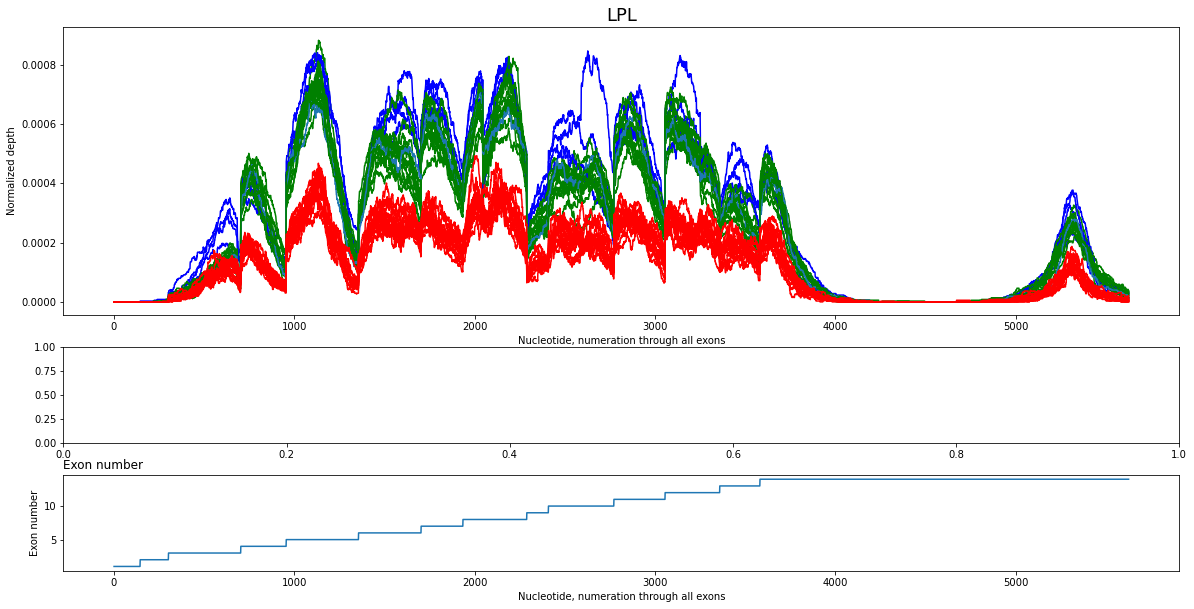

In [142]:
# Непосредственно построение графика
selected_colors = ["#7DC3DD","#DE9B3E","#E8ADC5","#CFBC73","#609C71","#DDE6E0","#838191","#E3E347","#B9E276","#DF8DDA", "#B9A4E4","#DB657C","#E2604E","#5E54DA","#867BDB","#72A3DF","#882DE3","#86EA52","#D2C3DE", "#AC5CDC","#D0967C","#D9C7AD","#E278E8","#71E4CA", "#6FE394","#8E5485","#C5E8B4","#96E4E3"]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, sharey='row', figsize = (20, 10), gridspec_kw={'height_ratios': [3, 1, 1]})

c_n = 0
for i in panel_samples_full_names:
    # смена цвета по списку
    #c = selected_colors[c_n]        # смена цвета по списку
    c_n = (c_n + 1 )%28

    c = color_of_sample_based_on_pca(i)

    #int(df_total_reads.at[i.split(".")[0], "number of mapped reads"]) --  число замапленых ридов для этого образца 
    ax1.plot(df_gene.index.tolist(), df_gene[str(i)]/int(df_total_reads.at[i.split(".")[0], "number of mapped reads"]),   #ax.plot = lines или ax.scatter
    label = "sample " + str(i),
    color = c)    # color = c  если хотим красивую сменяемость цветов

ax1.set_title(gene_title, fontsize=18)
ax1.set_ylabel('Normalized depth')
ax1.set_xlabel("Nucleotide, numeration through all exons")

ax3.plot(df_gene.index.tolist(), df_gene["exon_data"])
ax3.set_title('Exon number', loc = "left")
ax3.set_ylabel('Exon number')
ax3.set_xlabel("Nucleotide, numeration through all exons")

plt.savefig("./Results/" + panel_title + ": " + gene_title + " without findings.png", dpi = 400)
plt.show()